### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential

### Importing Skin Cancer Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Defining the path for train and test images

In [ ]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

### Load images for melanoma detection using keras.preprocessing

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Train and validation split. (Note: Resize images in dataset)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data

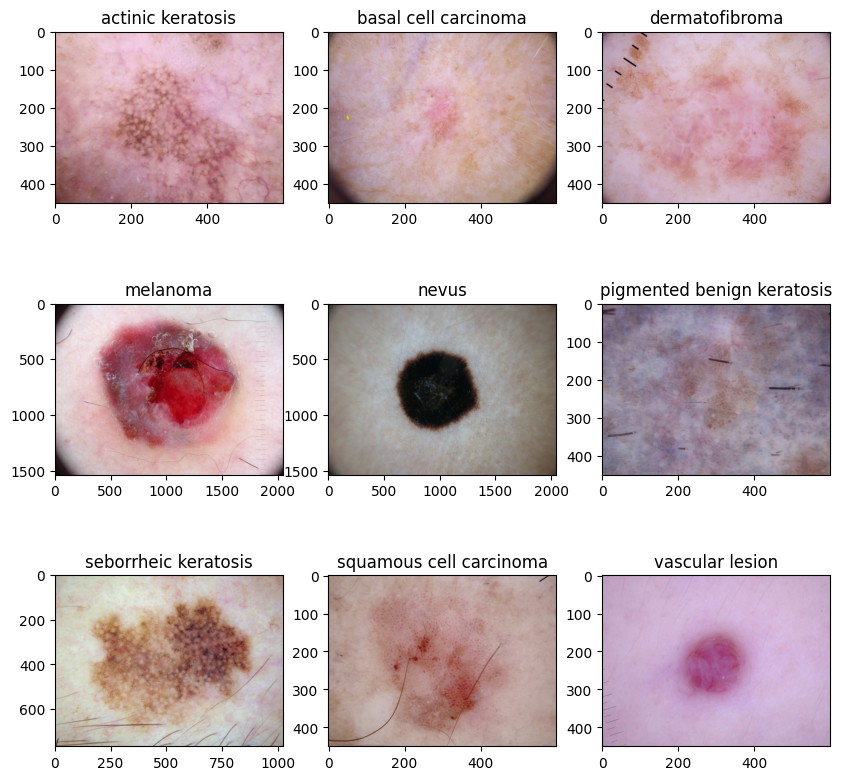

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Rescaling
num_classes = 9
model = Sequential([
                    Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 22, 22, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9)                   │          69,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,129 (1.06 MB)

 Trainable params: 277,129 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.1897 - loss: 2.0683 - val_accuracy: 0.1499 - val_loss: 2.0323
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.1816 - loss: 2.0256 - val_accuracy: 0.2081 - val_loss: 2.0188
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2067 - loss: 2.0136 - val_accuracy: 0.2081 - val_loss: 2.0371
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.2141 - loss: 2.0099 - val_accuracy: 0.1499 - val_loss: 2.0459
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.1993 - loss: 2.0315 - val_accuracy: 0.1924 - val_loss: 2.0263
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.2046 - loss: 2.0152 - val_accuracy: 0.1924 - val_loss: 2.0269
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1810 - loss: 2.0283 - val_accuracy: 0.2081 - val_loss: 2.0226
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.1844 - loss: 2.0221 - val_accuracy: 0.2058 - val_loss: 2.

# Visualizing training results

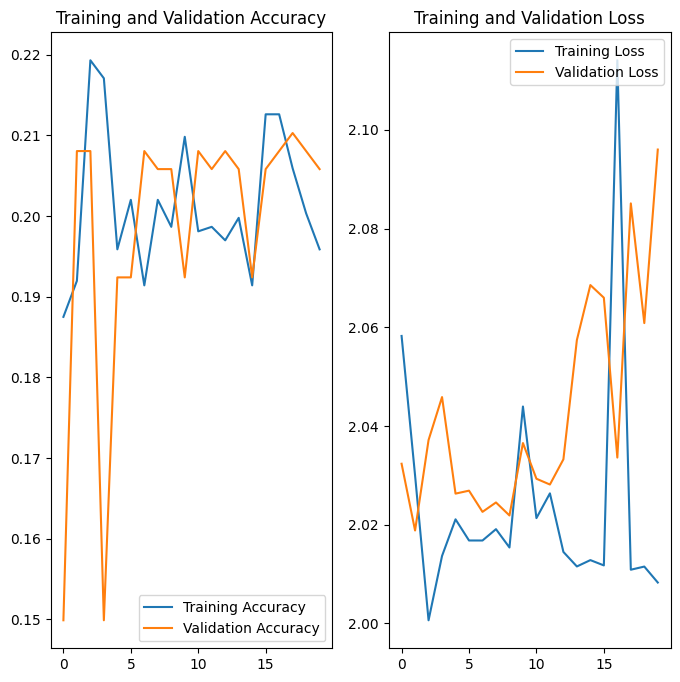

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Finding on the first base model

The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

The accuracy is just around 75-80% because there are enough features to remember the pattern.

But again, it's too early to comment on the overfitting & underfitting debate

#### Using Augmentor to reduce imbalance

In [ ]:
data_augument = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode='reflect'),
    layers.RandomZoom(0.2, fill_mode='reflect')
])

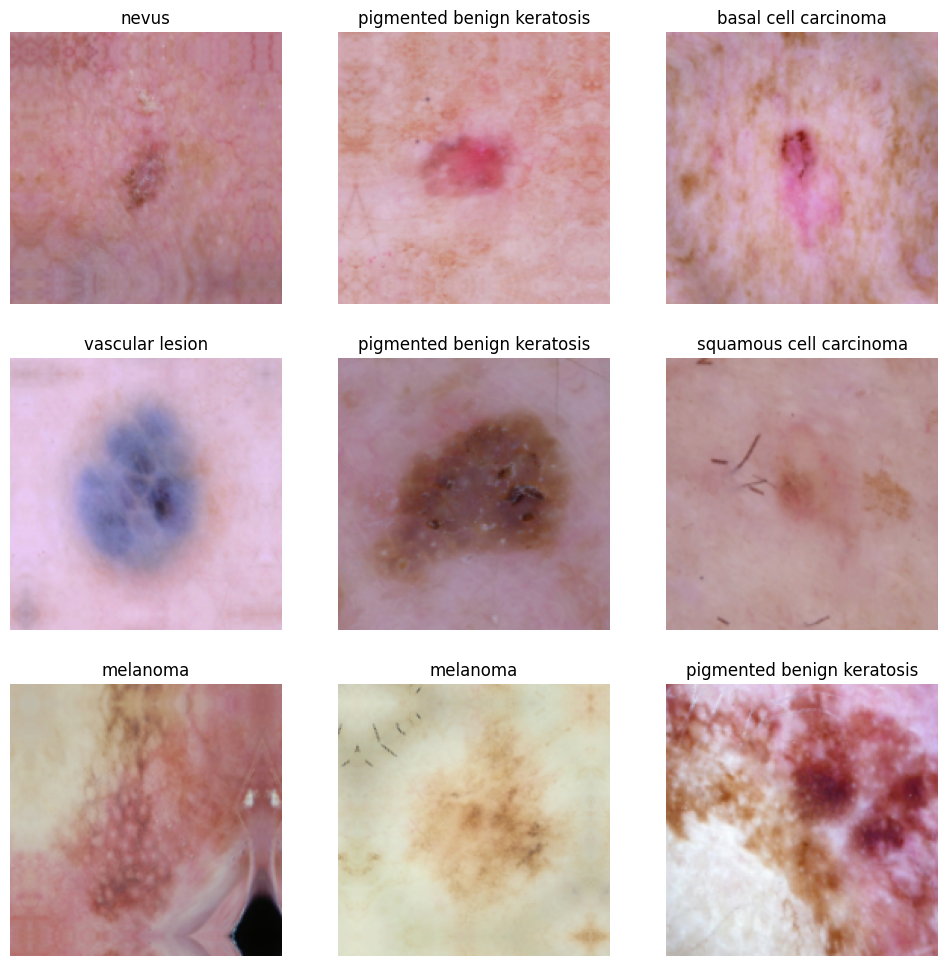

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create a model

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Rescaling
num_classes = 9
model = Sequential([
                    Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile a model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.1672 - loss: 2.1008 - val_accuracy: 0.2058 - val_loss: 2.0330
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.2049 - loss: 2.0174 - val_accuracy: 0.1790 - val_loss: 1.9895
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2367 - loss: 1.9671 - val_accuracy: 0.1902 - val_loss: 2.1158
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.2260 - loss: 2.0302 - val_accuracy: 0.2371 - val_loss: 2.0015
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.2278 - loss: 2.0309 - val_accuracy: 0.2394 - val_loss: 1.9821
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.2613 - loss: 1.9387 - val_accuracy: 0.2170 - val_loss: 2.0089
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.2276 - loss: 1.9642 - val_accuracy: 0.2304 - val_loss: 2.0668
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2028 - loss: 1.9890 - val_accuracy: 0.2953 

### Visualizing the results

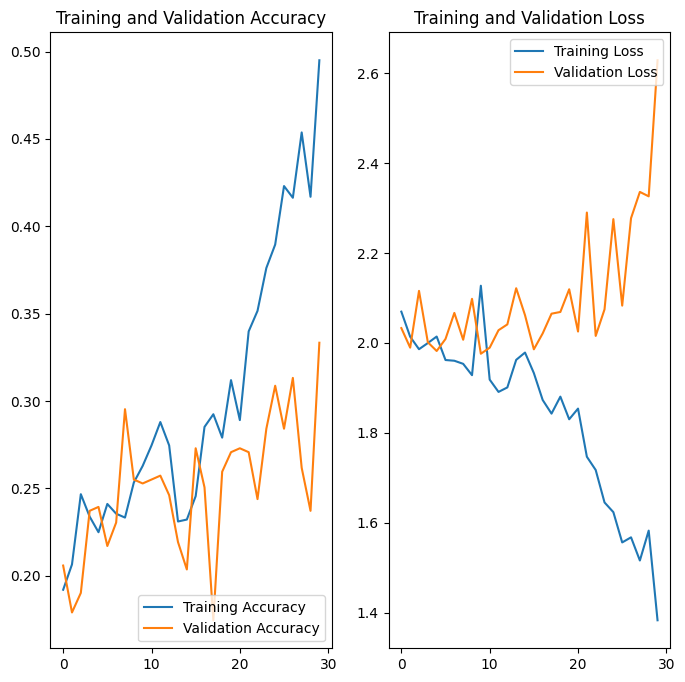

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Finding from Second Model

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy

#### Distribution of augmented data

In [ ]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2235,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2236,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2237,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion


In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2235,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2236,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2237,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion


<BarContainer object of 9 artists>

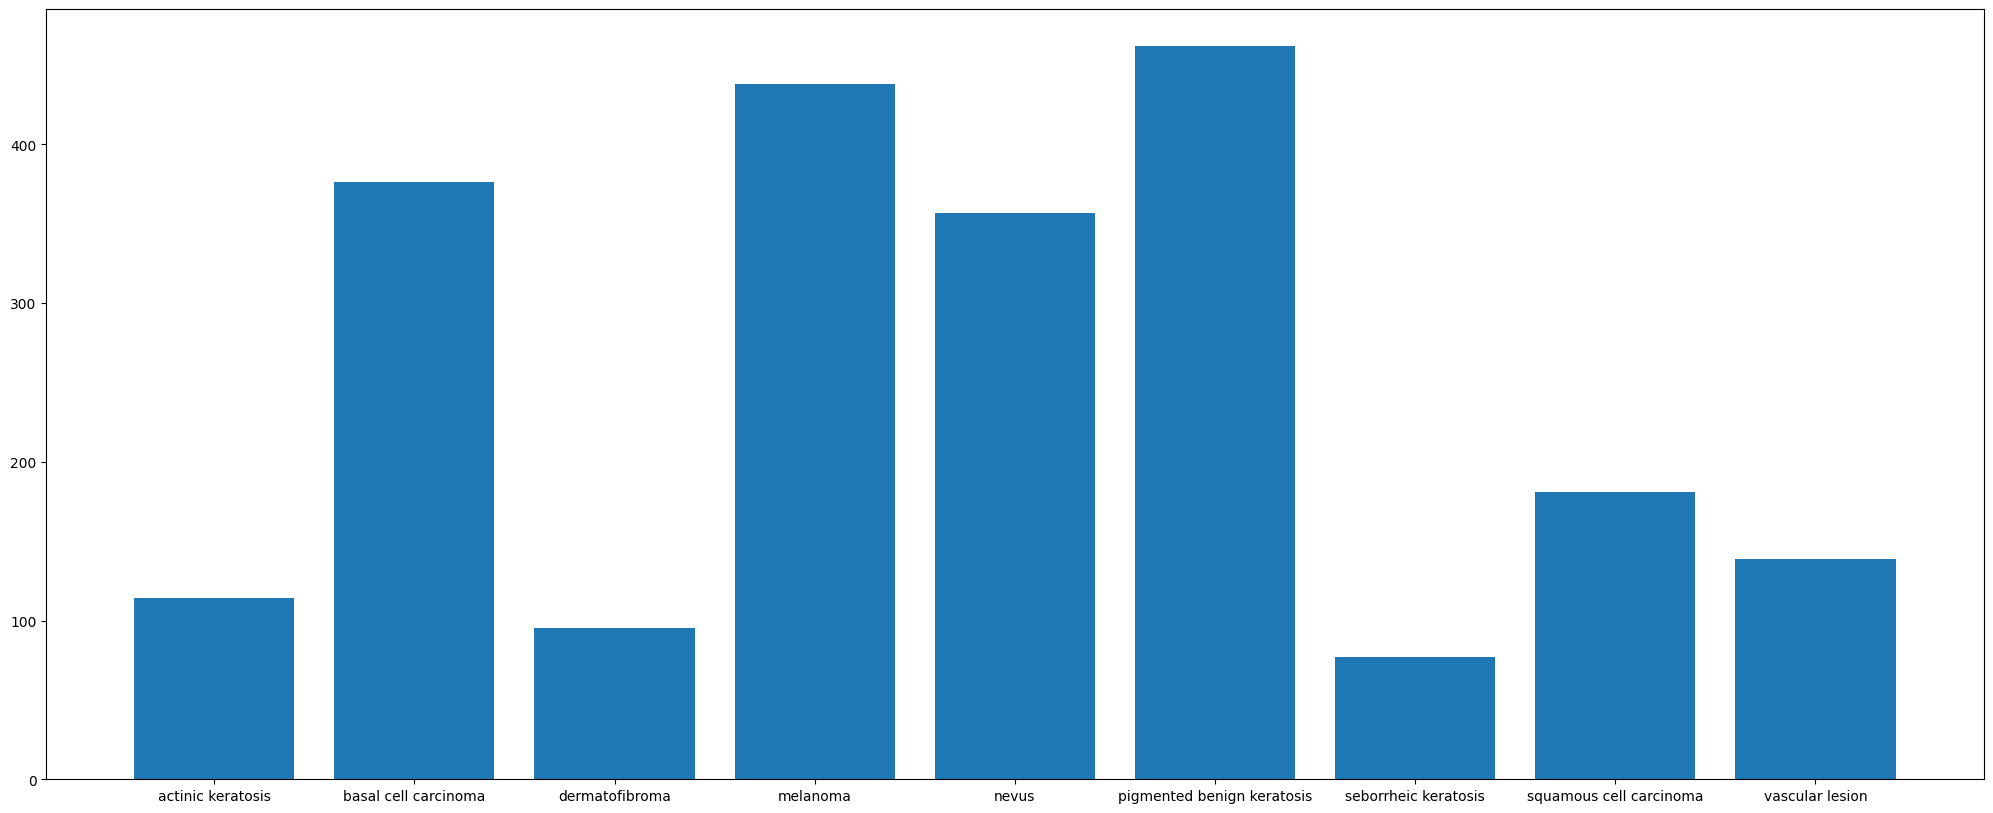

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

##### Findings
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?

Answer-1 :- squamous cell carcinoma has least number of samples

Answer-2:- actinic keratosis and dermatofibroma have proportionate number of classes.
melanoma and pigmented benign keratosis have proprtionate number of classes

In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
!pip install Augmentor


#### Rectifying the class imbalance

In [ ]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7BC64A1502B0>: 100%|██████████| 500/500 [00:58<00:00,  8.48 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BC63CD6A530>: 100%|██████████| 500/500 [00:39<00:00, 12.59 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7BC63CE9F8B0>: 100%|██████████| 500/500 [00:48<00:00, 10.34 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BC64A133970>: 100%|██████████| 500/500 [00:45<00:00, 11.10 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BC63CD70280>: 100%|██████████| 500/500 [00:53<00:00,  9.38 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BC63CD6B790>: 100%|██████████| 500/500 [00:48<00:00, 10.27 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7BC64A1326B0>: 100%|██████████| 500/500 [00:45<00:00, 11.11 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BC63CD70E20>: 100%|██████████| 500/500 [00:49<00:00, 10.12 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BC63CF5F0A0>: 100%|██████████| 500/500 [00:39<00:00, 12.58 Samples/s]


In [ ]:
data_dir_train1 = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [ ]:
for i in class_names:

    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
...,...,...
6734,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
6735,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
6736,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
6737,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion


In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,1343
melanoma,1324
basal cell carcinoma,1139
nevus,1094
squamous cell carcinoma,565
vascular lesion,430
actinic keratosis,318
dermatofibroma,292
seborrheic keratosis,234


#### Train the model on the data created using augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
import pathlib
data_dir_train1=pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

In [ ]:
data_dir_train1

PosixPath('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output')

In [ ]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


# Create a training dataset

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_dir_train1=pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.
Found 6739 files belonging to 10 classes.
Using 5392 files for training.


## Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


## Create a model (Make sure to include normalization)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Rescaling
num_classes = 9
model = Sequential([
                    Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model (Choose optimizer and loss function appropriately)

In [ ]:
epochs =30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 316ms/step - accuracy: 0.0512 - loss: nan - val_accuracy: 0.0267 - val_loss: nan
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 273ms/step - accuracy: 0.0240 - loss: nan - val_accuracy: 0.0267 - val_loss: nan
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 271ms/step - accuracy: 0.0236 - loss: nan - val_accuracy: 0.0267 - val_loss: nan
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 284ms/step - accuracy: 0.0232 - loss: nan - val_accuracy: 0.0267 - val_loss: nan
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 94s 354ms/step - accuracy: 0.0234 - loss: nan - val_accuracy: 0.0267 - val_loss: nan
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 262ms/step - accuracy: 0.0237 - loss: nan - val_accuracy: 0.0267 - val_loss: nan
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 263ms/step - accuracy: 0.0235 - loss: nan - val_accuracy: 0.0267 - val_loss: nan
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 262ms/step - accuracy: 0.0248 - loss: nan - val_accuracy: 0.0267 - val_loss: nan
Epoch 9/30


## Visualize the results

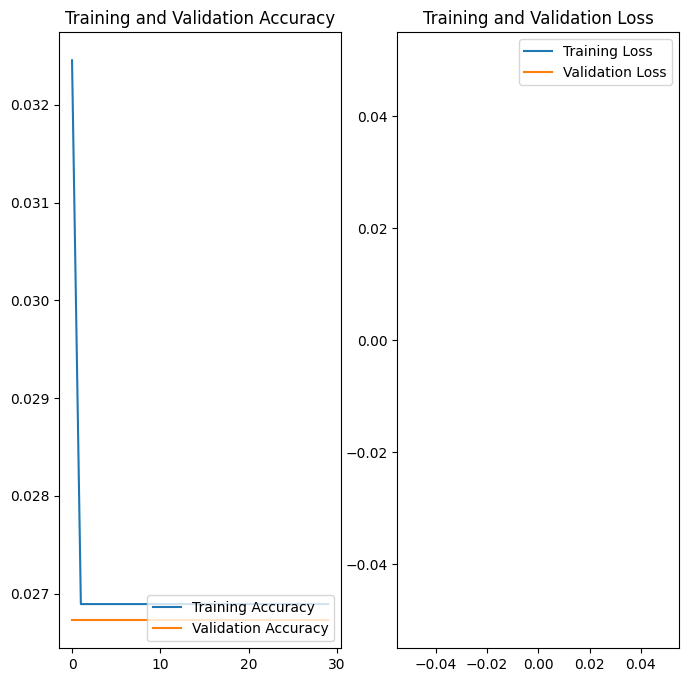

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Results
Accuracy on training data has increased by using Augmentor library

Model is still overfitting, more epochs can be used to overcome.

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

The Model can be further improved by tuning the hyperparameter